#####  Notebook editor: Anastasios-Polykarpos Athanasiadis

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mstats
from numba import jit, njit, vectorize
from scipy.integrate import solve_ivp, quad

from tqdm import tqdm
from pathlib import Path


In [54]:
plt.style.use('ggplot')

In [55]:
%%javascript
/* for automatic equations numbering */
/* source: https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/equation-numbering */
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

#### 1. Pitchfork bifurcation - Deterministic

\begin{equation}\label{SDE}
    \dot{x} = q(x(t)) + g(x(t))\xi(t) 
\end{equation}

\begin{equation}\label{SDE_}
    \eqref{SDE}\Rightarrow\dot{x} = x(t) - x(t)^3 + 1\xi(t)
\end{equation}

Numerical solution

In [56]:
def q(t, x, a): return a*x - x**3

In [57]:
alphas = np.linspace(-4, +4, 100) # alphas.shape = (100,)

In [58]:
initial_conditions = np.arange(-1, 1+0.2, 0.2) # inital_conditions.shape = (11,)

In [59]:
t0 = 0
tmax = 10

In [60]:
trajectory = {}
for i,alpha in enumerate(alphas):
    for j,ic in enumerate(initial_conditions):
        trajectory[i,j] = solve_ivp(q, (t0, tmax), (ic,), args = (alpha,))
# sol = probsolve_ivp(q, [0, 20], [2, -2, 0.4], args = (4,) -> doesnt exist)

In [61]:
Tdet = np.empty((len(alphas), len(initial_conditions)), dtype = object)
Xdet = np.zeros((len(alphas), len(initial_conditions)), dtype = object)
for i in range(len(alphas)):
    for j in range(len(initial_conditions)):
        Tdet[i, j] = trajectory[i,j]["t"]
        Xdet[i, j] = trajectory[i,j]["y"]

In [62]:
for i,j in enumerate(initial_conditions):
    print(i,j)

for i,j in enumerate(alphas):
    print(i,j)

0 -1.0
1 -0.8
2 -0.6000000000000001
3 -0.40000000000000013
4 -0.20000000000000018
5 -2.220446049250313e-16
6 0.19999999999999973
7 0.3999999999999997
8 0.5999999999999996
9 0.7999999999999996
10 0.9999999999999996
0 -4.0
1 -3.919191919191919
2 -3.8383838383838382
3 -3.757575757575758
4 -3.676767676767677
5 -3.595959595959596
6 -3.515151515151515
7 -3.4343434343434343
8 -3.3535353535353534
9 -3.2727272727272725
10 -3.191919191919192
11 -3.111111111111111
12 -3.0303030303030303
13 -2.9494949494949494
14 -2.8686868686868685
15 -2.787878787878788
16 -2.7070707070707067
17 -2.6262626262626263
18 -2.5454545454545454
19 -2.4646464646464645
20 -2.3838383838383836
21 -2.3030303030303028
22 -2.2222222222222223
23 -2.141414141414141
24 -2.0606060606060606
25 -1.9797979797979797
26 -1.8989898989898988
27 -1.818181818181818
28 -1.737373737373737
29 -1.6565656565656566
30 -1.5757575757575757
31 -1.4949494949494948
32 -1.414141414141414
33 -1.333333333333333
34 -1.2525252525252522
35 -1.1717171717171

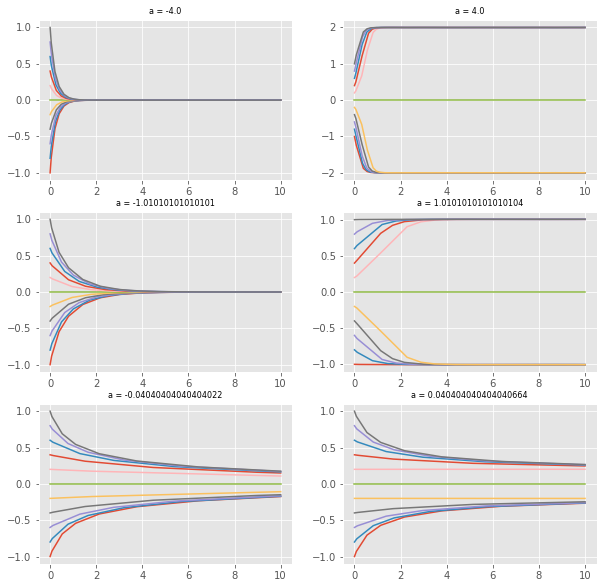

In [63]:
fig, ax = plt.subplots(3,2, figsize = (10,10))
for i, ic in enumerate(initial_conditions):
    ax[0,0].plot(Tdet[0, i], Xdet[0, i][0,:])
    ax[0,0].set_title('a = {}'.format(alphas[0]), fontsize = 8)
    ax[0,1].plot(Tdet[-1, i], Xdet[-1, i][0, :])
    ax[0,1].set_title('a = {}'.format(alphas[-1]), fontsize = 8)
    ax[1,0].plot(Tdet[37, i], Xdet[37, i][0,:])
    ax[1,0].set_title('a = {}'.format(alphas[37]), fontsize = 8)
    ax[1,1].plot(Tdet[62, i], Xdet[62, i][0,:])
    ax[1,1].set_title('a = {}'.format(alphas[62]), fontsize = 8)
    ax[2,0].plot(Tdet[49, i], Xdet[49, i][0,:])
    ax[2,0].set_title('a = {}'.format(alphas[49]), fontsize = 8)
    ax[2,1].plot(Tdet[50, i], Xdet[50, i][0,:])
    ax[2,1].set_title('a = {}'.format(alphas[50]), fontsize = 8)
# plt.legend()
plt.show()

In [64]:
Xdet_alphas = np.zeros((len(alphas), len(initial_conditions)))
for j in range(len(initial_conditions)):
    for i in range(len(alphas)):
        Xdet_alphas[i, j] = Xdet[:, j][i][0,:][-1]

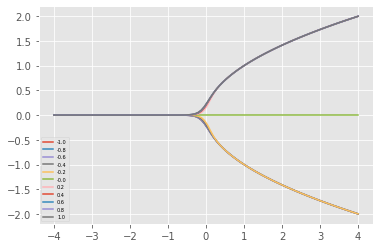

In [65]:
for i, ic in enumerate(initial_conditions):
    plt.plot(alphas, Xdet_alphas[:, i], label = '{}'.format(ic.round(2)))
plt.legend(loc = 'lower left', prop = {'size': 5})
plt.show()

### Milshtein algoritm, page 199pdf

##### *Milstein algorithm $\equiv$ Euler-Maruyama algorithm*, for $g(x(t)) = const$

In [66]:
@njit()
def q(x, t, a):
    '''ax - x^3'''
    return a*x - x**3
@njit()
def g(x, t, D):
    '''\sqrt{D}'''
    return np.sqrt(D)

In [67]:
# Parameter values (taken by figure 7.4 page 222) 
a = 1
D = 1
# Initial conditions 
x_0 = 0
t_0 = 0
# dg/dx
g_prime = 0

#### 1. Simulate single trajectory

In [68]:
h = 0.01   # time step of numerical calculation
h_sqrt = np.sqrt(h)
n_write = 200
n_step = 10

In [69]:
@njit()
def Euler_Maruyama(n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                   a = a, D = D, x_0 = x_0, t_0 = t_0, U = np.random.normal(loc = 0.0, scale = 1.0, size = int(n_write*n_step)).reshape(n_step, n_write)):
    '''
    SDE:    dx/dt   = q(a, x(t)) + g(x(t))ξ(t)
    input:  h       = time step of numerical calculation
            n_step  = #numerical calculations before storing x value
            n_write = #records of x value
            U       = Random Variable of Noise, size (n_step*n_write) 
    output: trajectory of the SDE solution, for standard gaussian noise
    return: T(n_write), X(n_write)
    '''
    X = np.zeros(n_write)
    T = np.zeros_like(X)
#     U = np.reshape(U, (n_step, n_write, -1))
    x = x_0
    t = t_0
    for i_write in range(n_write):
        for i_step in range(n_step):
#             print(U[i_step, i_write].shape)
            uh = h_sqrt * U[i_step, i_write]  #np.random.normal(loc = 0.0, scale = 1.0) #ui, indepednent Gaussian RV
            x = x + h * q(x, t, a) + g(x, t, D) * uh + 0.5 * g(x, t, D) * g_prime * h * uh**2 #+ bigger order corrections 
            t = t + h
        # store every h*n_step = 0.1 time units
#         print(x.shape)
        X[i_write] = x 
        T[i_write] = t 
    return T, X

In [70]:
%time _ = Euler_Maruyama()

CPU times: user 935 ms, sys: 3.98 ms, total: 939 ms
Wall time: 1.01 s


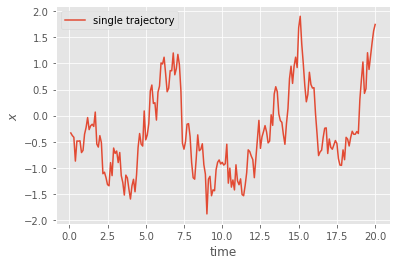

In [71]:
T, X = Euler_Maruyama()
plt.plot(T, X, label = 'single trajectory')
plt.xlabel('time')
plt.ylabel(r'$x$')
plt.legend()
plt.show()

In [137]:
@njit()
def Euler_Maruyama_mean(n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                        a = a, D = D, x_mean = 0, x_0 = x_0, t_0 = t_0,
                        U = np.random.normal(loc = 0.0, scale = 1.0, size = int(n_write*n_step))):
    '''
    SDE:    dx/dt   = q(a, x(t)) + g(x(t))ξ(t)
    input:  h       = time step of numerical calculation
            n_step  = #numerical calculations before storing x value
            n_write = #records of x value
            U       = Random Variable of Noise, size (n_step*n_write) 
    output: trajectory of the SDE solution, for standard gaussian noise
    return: T(n_write), X(n_write)
    '''
    x = x_0
    t = t_0
#     x_mean = x_mean
    for i in range(int(n_write*n_step)):
        uh = h_sqrt * U[i]  #np.random.normal(loc = 0.0, scale = 1.0) #ui, indepednent Gaussian RV
        x_step = h * q(x, t, a) + g(x, t, D) * uh + 0.5 * g(x, t, D) * g_prime * h * uh**2 #+ bigger order corrections
        x = x + x_step
        x_mean += (x - x_mean)/(i+1) #i starts from 0          
        t = t + h
            
    return x_mean, x, t

In [142]:
%time _ = Euler_Maruyama_mean()

CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 1.18 ms


In [74]:
#to check that noise is random
for i in range(2):
    print(Euler_Maruyama_mean(U=np.random.normal(loc = 0.0, scale = 1.0, size = int(n_write*n_step))))

(0.09567578061418329, -0.025405500113575206, 20.000000000000327)
(-0.4947126583894482, -1.0542998672443604, 20.000000000000327)


#### 2. Simulate `n_sim` trajectories

In [75]:
# number of simulated trajectories
n_sim = 1e4
n_sim = int(n_sim)
# initial conditions of each trajectory
x_0 = np.zeros(n_sim)

In [76]:
# @njit()
def Trajectories_Euler_Maruyama(n_sim = n_sim, func = Euler_Maruyama, 
                                n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                                a = a, D = D, x_0 = np.zeros(n_sim), t_0 = t_0, 
                                U = np.random.normal(loc = 0.0, scale = 1.0, size = n_write*n_step*n_sim).reshape(n_step, n_write, n_sim)):
    X = np.zeros([n_write, n_sim])
#     U_ = U#.reshape(n_step, n_write, n_sim)
    for j in range(n_sim):
        x0 = x_0[j]
        U_ = U[:, :, j]
        X[:, j] = func(n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                       a = a, D = D, x_0 = x0, t_0 = t_0, U = U_)[1]
    return func()[0], X

In [77]:
T, X = Trajectories_Euler_Maruyama(x_0 = np.zeros(n_sim))

In [78]:
%time _ = Trajectories_Euler_Maruyama(n_write = 200)

CPU times: user 450 ms, sys: 12 ms, total: 462 ms
Wall time: 463 ms


In [79]:
X.shape

(200, 10000)

In [80]:
X_bar = np.mean(X, axis = 1) # average across the simulated trajectories

X_var = np.var(X, axis = 1) # variance across simulated trajectories

quantiles = mstats.mquantiles(X, axis=1)

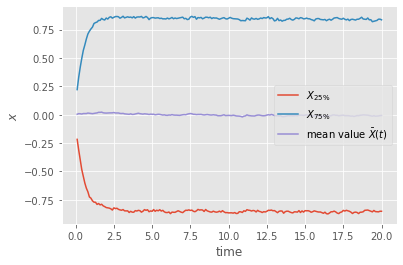

In [81]:
X_25, X_75 = quantiles[:,0], quantiles[:,2]
plt.plot(T, X_25, label=r'$X_{25\%}$')
plt.plot(T, X_75, label=r'$X_{75\%}$')
plt.plot(T, X_bar, label = r'mean value $\bar{X}(t)$');
# plt.fill_between(T, X_bar + X_var, X_bar - X_var, alpha = 0.3) # X_var ~ 0 
plt.xlabel('time')
plt.ylabel(r'$x$')
plt.legend(loc = 'center right')
plt.show()

Since the trajectory can stabilize to either $+\sqrt{a}$ or $-\sqrt{a}$, we next plot the mean of $X>0$ (and use $std(X|X>0)$ for error estimation) and $\mathbb{E}(X| X<0) \pm std(X|X<0)$. 

In [82]:
Xpos = X[:, X.mean(axis = 0)>0]
Xneg = X[:, X.mean(axis = 0)<0]
# mean across simulated trajectories
Xpos_bar = Xpos.mean(axis = 1)
Xneg_bar = Xneg.mean(axis = 1)
# std across simulated trajectories
Xpos_std = np.std(Xpos, axis = 1) 
Xneg_std = np.std(Xneg, axis = 1) 

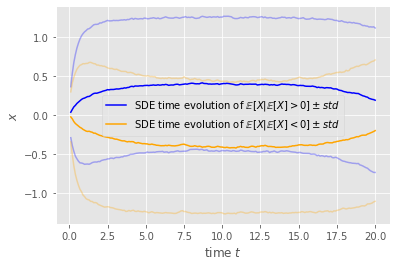

In [84]:
plt.plot(T, Xpos_bar, color = 'blue', label = r'SDE time evolution of $\mathbb{E}[X|\mathbb{E}[X]>0]\pm std$');
plt.plot(T, Xneg_bar, color = 'orange', label = r'SDE time evolution of $\mathbb{E}[X|\mathbb{E}[X]<0]\pm std$');
plt.plot(T, Xpos_bar + Xpos_std, alpha = 0.3, color = 'b') 
plt.plot(T, Xpos_bar - Xpos_std, alpha = 0.3, color = 'b') 
plt.plot(T, Xneg_bar - Xneg_std, alpha = 0.3, color = 'orange')
plt.plot(T, Xneg_bar + Xneg_std, alpha = 0.3, color = 'orange')
# plt.vlines(T[10], Xneg_bar[10], Xneg_bar[10] + Xneg_std[10], alpha = 0.5, color = 'orange')
# plt.vlines(T[10], Xneg_bar[10], Xneg_bar[10] - Xneg_std[10], alpha = 0.5,color = 'orange')
# plt.vlines(T[-10], Xneg_bar[-10], Xneg_bar[-10] + Xneg_std[-10],alpha = 0.5, color = 'orange')
# plt.vlines(T[-10], Xneg_bar[-10], Xneg_bar[-10] - Xneg_std[-10], alpha = 0.5,color = 'orange')
# plt.vlines(T[20], Xpos_bar[20], Xpos_bar[20] + Xpos_std[20],alpha = 0.5, color = 'b')
# plt.vlines(T[20], Xpos_bar[20], Xpos_bar[20] - Xpos_std[20],alpha = 0.5, color = 'b')
# plt.vlines(T[-20], Xpos_bar[-20], Xpos_bar[-20] + Xpos_std[-20],alpha = 0.5, color = 'b')
# plt.vlines(T[-20], Xpos_bar[-20], Xpos_bar[-20] - Xpos_std[-20],alpha = 0.5, color = 'b')
plt.xlabel(r'time $t$')
plt.ylabel(r'$x$')
plt.legend()
plt.show()

**Note:** The issue is that the trajectories jumps from $1$ to $-1$ and vice versa, so they aren't clearly positive or negative. That's why next I plot the mean of $|X|$.

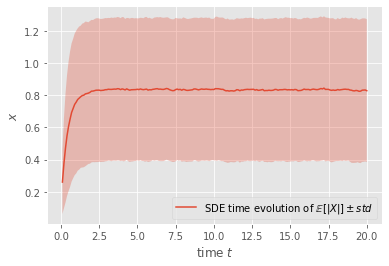

In [85]:
plt.plot(T, np.abs(X).mean(axis = 1), label = r'SDE time evolution of $\mathbb{E}[|X|]\pm std$');
plt.fill_between(T, np.abs(X).mean(axis = 1) + np.std(np.abs(X), axis = 1), np.abs(X).mean(axis = 1) - np.std(np.abs(X), axis = 1), alpha = 0.3) 
plt.legend(loc = 'lower right')
plt.xlabel(r'time $t$')
plt.ylabel(r'$x$')
plt.show()

#### 3. Compute stochastic solution for different fixed $\lambda$ (or $a$ ) and compare with the determistic solution

In [86]:
initial_conditions_ = np.linspace(-10, 10, n_sim) # inital_conditions.shape = (n_sim,)

##### new

In [27]:
def Trajectories_Euler_Maruyama_mean_across_time(n_sim = n_sim, func = Euler_Maruyama_mean, 
                                                 n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                                                 a = a, D = D, x_mean = np.zeros(n_sim), x_0 = np.zeros(n_sim), t_0 = t_0, 
                                                 U = np.random.normal(loc = 0.0, scale = 1.0, size = n_write*n_step*n_sim).reshape(n_step*n_write, n_sim)):
    X_mean = np.zeros(n_sim) # initialization
    X = np.zeros(n_sim) # initialization
#     print(x_mean.shape, x_0.shape)
    #     U_ = U#.reshape(n_step, n_write, n_sim)
    for j in range(n_sim):
        x0 = x_0[j] # j initial value from the array for x0
        U_ = U[:, j]
        X_mean[j], X[j], t = func(n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                                  a = a, D = D, x_mean = x_mean[j], x_0 = x0, t_0 = t_0, U = U_)
    return X_mean, X, t

In [29]:
%time _ = Trajectories_Euler_Maruyama_mean_across_time(n_write = 200, x_0 = np.zeros(n_sim))

CPU times: user 347 ms, sys: 3.94 ms, total: 351 ms
Wall time: 350 ms


In [30]:
X_mean_alphas = np.zeros((n_sim, len(alphas))) # x_mean of each trajectory for each alpha -> input for x_mean
X_trajs = np.zeros((n_sim, len(alphas))) # x at the end of each trajectory for each alpha -> input for x_0
T = np.zeros(len(alphas))

In [31]:
# recursively reach 5000 time steps due to RAM issues
for f in tqdm(range(int(5000/200))): # int(desired time/max.time due to RAM)
    for i, a in enumerate(alphas):
        X_mean_alphas[:, i], X_trajs[:, i], T[i] = Trajectories_Euler_Maruyama_mean_across_time(n_write = 200, a = a,
                                                                                                x_mean = X_mean_alphas[:,i], x_0 = X_trajs[:,i], t_0 = T[i])

100%|██████████| 25/25 [12:30<00:00, 30.01s/it]


In [35]:
###### USING THE FILES ##############

In [50]:
# X_mean_alphas = np.zeros((n_sim, len(alphas)))
# for f in tqdm(range(20)):
#     for i, a in enumerate(alphas):
#         X_mean_alphas[:, i] = Trajectories_Euler_Maruyama_mean_across_time(n_write = 250, a = a, x_0 = np.zeros(n_sim))
#     np.save("x_a_mean_files/X_a_mean"+str(f), X_mean_alphas)

100%|██████████| 20/20 [12:00<00:00, 36.00s/it]


In [61]:
# X_mean_alphas_full = np.load("x_a_mean_files/X_a_mean"+str(f)+".npy")
# for f in tqdm(range(1,20)):
#     X_mean_alphas_full = np.vstack((X_mean_alphas_full, np.load("x_a_mean_files/X_a_mean"+str(f)+".npy")))

100%|██████████| 19/19 [00:01<00:00, 16.06it/s]


In [36]:
#####################################

In [32]:
alphas_sqrt_range = (-0.1-np.sqrt(alphas[-1]), 0.1+np.sqrt(alphas[-1])) #+- 0.1 from stochasticity component
Bins = np.linspace(alphas_sqrt_range[0], alphas_sqrt_range[1], 100)
Freqs = np.zeros((len(Bins)-1, len(alphas)))
for a in range(len(alphas)):
    Freqs[:, a] = np.histogram(a=X_mean_alphas[:, a], #alpha ~ 4
                               bins = Bins, density = True)[0]

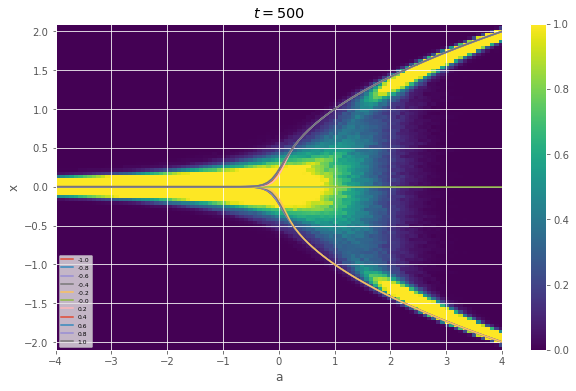

In [99]:
plt.figure(figsize=(10,6))
plt.imshow(Freqs, vmin=0, vmax=1, #cmap=plt.get_cmap('hot'),
           extent=[-4, 4, -2.1, 2.1], aspect='auto', label = 'pdf')
for i, ic in enumerate(initial_conditions):
    plt.plot(alphas, Xdet_alphas[:, i], label = '{}'.format(ic.round(2)))
plt.legend(loc = 'lower left', prop = {'size': 6})
plt.xlabel('a')
plt.ylabel('x')
plt.title(r'$t=500$')
plt.colorbar()
plt.show()

##### old

In [100]:
X_alphas = np.zeros((200, X.shape[1], len(alphas)))
for i, a in enumerate(tqdm(alphas)):
    X_alphas[:, :, i] = Trajectories_Euler_Maruyama(a = a, x_0 = initial_conditions_)[1]

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


In [102]:
X_alphas.shape # (time, trajectories, alpha)

(200, 10000, 100)

In [103]:
X_alphas.mean(axis = 0).shape #mean over time

(10000, 100)

In [104]:
alphas_sqrt_range = (-0.1-np.sqrt(alphas[-1]), 0.1+np.sqrt(alphas[-1])) #+- 0.1 from stochasticity component
Bins = np.linspace(alphas_sqrt_range[0], alphas_sqrt_range[1], 100)
Freqs = np.zeros((len(Bins)-1, len(alphas)))
for a in range(len(alphas)):
    Freqs[:, a] = np.histogram(a=X_alphas.mean(axis=0)[:, a], #alpha ~ 4
                               bins = Bins, density = True)[0]

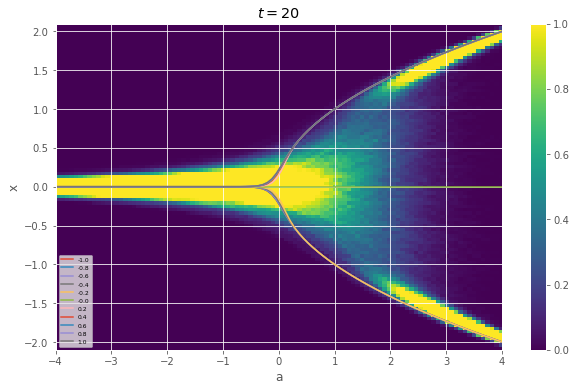

In [107]:
plt.figure(figsize=(10,6))
plt.plot()
plt.imshow(Freqs, vmin=0, vmax=1, 
           extent=[-4, 4, -2.1, 2.1], aspect='auto', label = 'pdf')
for i, ic in enumerate(initial_conditions):
    plt.plot(alphas, Xdet_alphas[:, i], label = '{}'.format(ic.round(2)))
plt.legend(loc = 'lower left', prop = {'size': 6})
plt.colorbar()
plt.xlabel('a')
plt.ylabel('x')
plt.title(r'$t=20$')
plt.show()

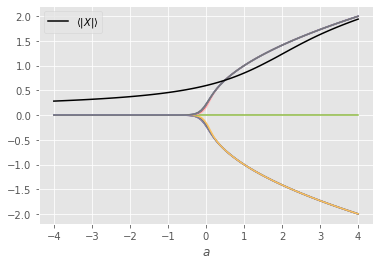

In [108]:
plt.plot(alphas, Xdet_alphas);
### x_alphas is overwritten with absolute positive values now###
plt.plot(alphas, np.abs(X_alphas, out = X_alphas).mean(axis = 1).mean(axis = 0), color = 'k', label = r'$\langle | X | \rangle$');
# plt.fill_between(alphas, X_alphas_mean + X_alphas_std, X_alphas_mean - X_alphas_std, alpha = 0.2, color = 'k')
plt.xlabel(r'$a$')
plt.legend()
plt.show()

#### 6. Construct a histogram with the values taken for the system over a long trajectory at the stationary state

After t=10, from the figure above it's concluded that the system is at the stationary state


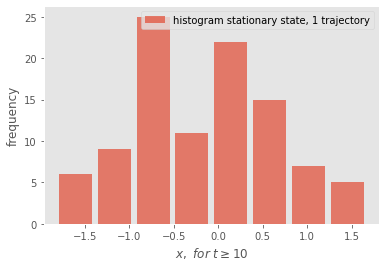

In [109]:
n, bins, patches = plt.hist(x=X[100:,0], 
                            bins='auto', alpha=0.7, rwidth=0.85, label = 'histogram stationary state, 1 trajectory')
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$x, \ for \ t \geq 10$')
plt.ylabel(r'frequency')
plt.legend()
plt.show()

#### 4. Construct a histogram with the values taken for the system over all trajectories at the stationary state

In [110]:
X_st_flat = X[100:, :].flatten()

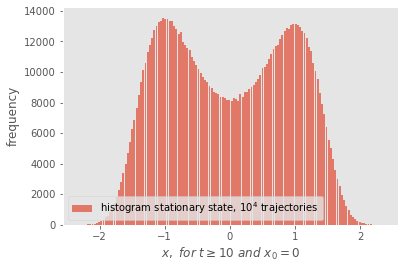

In [111]:
n, bins, patches = plt.hist(x=X_st_flat, bins='auto',
                            alpha=0.7, rwidth=0.85, label = r'histogram stationary state, $10^4$ trajectories')
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$x, \ for \ t \geq 10 \ and \ x_0 = 0$')
plt.ylabel(r'frequency')
plt.legend(loc = 'lower left')
plt.show()

#### 5. Exploring the decay to the stable states for different initial conditions

In [112]:
T, X_ = Trajectories_Euler_Maruyama(a = 1, x_0 = np.random.uniform(-5, 5, n_sim))

In [113]:
a = 1

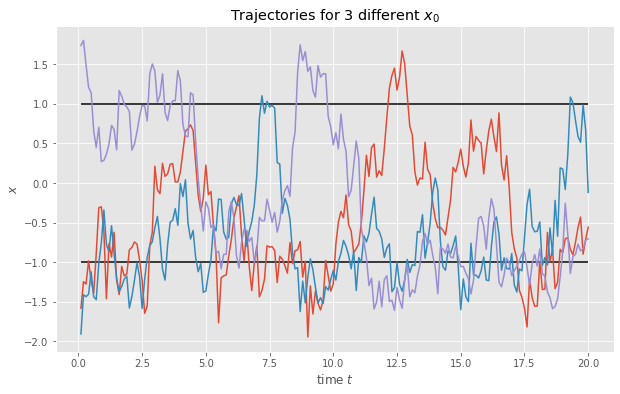

In [114]:
plt.figure(figsize=(10,6))
plt.plot(T, X_[:, :3]);
plt.hlines(a, T[0], T[-1], color = 'k')
plt.hlines(-a, T[0], T[-1], color = 'k')
plt.title(label = 'Trajectories for 3 different $x_0$')
plt.xlabel(r'time $t$')
plt.ylabel(r'$x$')
# plt.legend()
plt.show()

#### 6. Theoretical solution

Solving for the Fokker-Planck probability density function at the stationary situation, $f^{st}(t)$, from \eqref{SDE_}, for: $$ q(x) = -\frac{d}{dx}V(x) = x - x^3 \\
    \Leftrightarrow V(x) = -\frac{x^2}{2} + \frac{x^4}{4}.
$$
Then: $$ f^{st}(x) = e^{-2V(x)/D}/N
$$
taken from Berglund paper; where $\int_{-\infty}^{+\infty}f^{st}(x)dx = 1$ and $N$ is the normalization constant, for $g(x) = \sqrt{D}$

In [115]:
x = np.linspace(-3, 3)
V = -x**2/2 + x**4/4 
y = np.exp(-2*(-x**2/2 + x**4/4))/4.166 # N = 4.166, a = 1, D = 1

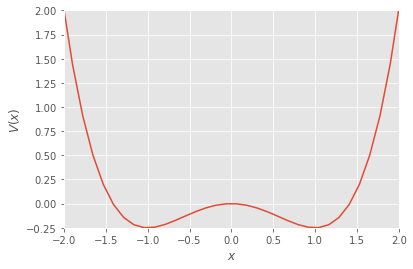

In [116]:
plt.plot(x, V);
plt.xlim(-2, +2)
plt.ylim(-0.25, 2)
plt.xlabel(r'$x$')
plt.ylabel(r'$V(x)$')
plt.show()

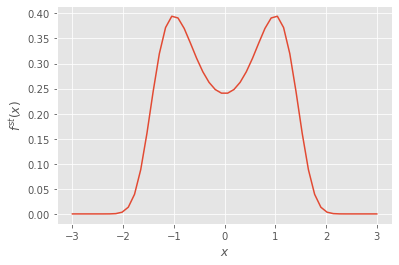

In [117]:
plt.plot(x, y);
plt.xlabel(r'$x$')
plt.ylabel(r'$f^{st}(x)$')
plt.show()

#### 7. Compare analytical with numerical stationary solution of the probablity density function that gives the probability to find the system at a given location $x$ in phase space at a time $t \gg 0$

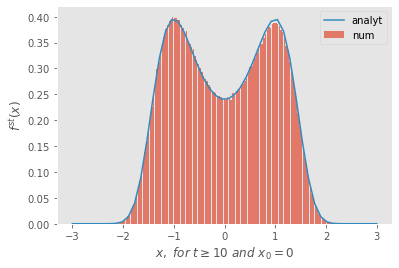

In [118]:
n, bins, patches = plt.hist(x=X_st_flat, bins='auto', density = True, # density=True normalizes the histogram
                            alpha=0.7, rwidth=0.85, label = r'num')
plt.plot(x, y, label = 'analyt');
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$x, \ for \ t \geq 10 \ and \ x_0 = 0$')
plt.ylabel(r'$f^{st}(x)$')
plt.legend()
plt.show()

for a = 4:

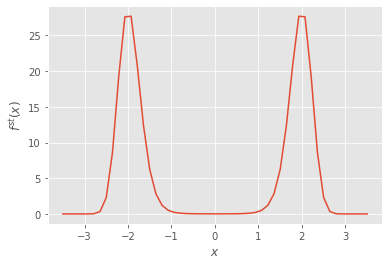

In [119]:
x = np.linspace(-3.5, 3.5)
y = np.exp(2*(4*x**2/2 - x**4/4))/103.5 
plt.plot(x, y);
plt.xlabel(r'$x$')
plt.ylabel(r'$f^{st}(x)$')
plt.show()

### Escape Time Problem

In [127]:
# Heun_first_passage_time program, page 224
# initial conditions
x_0 = -1 # stable point
t_0 = 0
# parameter values
a = 1
D = 1

x_b = 0.5 # point close to the other stable point
h = 0.01   # time step of numerical calculation
h_sqrt = np.sqrt(h)

t_max = 100.0 # program finishes after maximum time t_max
n_tra = int(1e4) # number of trajectories

##### new

In [173]:
@njit
def esc_time_Heun(t_max = t_max, n_tra = n_tra, h = h, h_sqrt = h_sqrt,
                  a = a, D = D, t_0 = t_0, x_0 = x_0, x_b = x_b):
#     X_A = [[] for i in range(n_tra)]
#     T_esc = [[] for i in range(n_tra)]
    Tpoints_esc = np.zeros(n_tra)
    for i_tra in range(n_tra): 
        x = x_0
        t = t_0
        while x < x_b:
            uh = h_sqrt * np.random.normal(loc = 0.0, scale = 1.0) #ui, indepednent Gaussian RV
            aux = h * q(x, t, a) + uh * g(x, t, D)
            x = x + 0.5 * (aux + h * q(x + aux, t + h, a) + uh * g(x + aux, t + h, D))
            t = t + h
            if t > t_max:
                t = -1
                break
#                 print('Trajectory, {}, has not crossed the boundary', format(i_tra))
#             X_A[i_tra].append(x) 
#             T_esc[i_tra].append(t)  
        Tpoints_esc[i_tra] = t
#     Tpoints_esc = np.array([sublist[-1] for sublist in T_esc])
    
    return Tpoints_esc#, T_esc, X_A

In [175]:
%time _ = esc_time_Heun()

CPU times: user 391 ms, sys: 4.04 ms, total: 395 ms
Wall time: 394 ms


In [176]:
Tpoints_esc_ = esc_time_Heun()

In [177]:
Tpoints_esc_.shape

(10000,)

In [178]:
xx = np.linspace(0,30,100)
λ = 1/Tpoints_esc_.mean()
TT = λ*np.exp(-λ*xx)

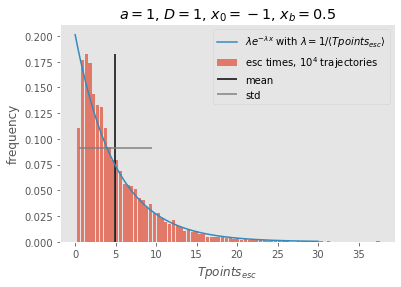

In [179]:
n, bins, patches = plt.hist(x=Tpoints_esc_, bins='auto', density = True, # normalized
                            alpha=0.7, rwidth=0.85, label = r'esc times, $10^4$ trajectories')
plt.plot(xx, TT, label = r'$\lambda e^{-\lambda x}$ with $\lambda = 1/\langle Tpoints_{esc} \rangle$')
plt.vlines(Tpoints_esc_.mean(), 0, n.max(), color = 'k', label = 'mean')
plt.hlines(n.max()/2, Tpoints_esc_.mean() - np.std(Tpoints_esc_), Tpoints_esc_.mean() + np.std(Tpoints_esc_), color = 'gray', label = 'std')
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$Tpoints_{esc}$')
plt.ylabel(r'frequency')
plt.title(r'$a = {}$, $D = {}$, $x_0 = {}$, $x_b = {}$'.format(a, D, x_0, x_b))
plt.legend()
plt.show()

In [199]:
alphas_pos = np.linspace(0.1, 4, 49)

In [203]:
Tpoints_esc_alphas = np.zeros((Tpoints_esc_.shape[0], len(alphas_pos)))

In [204]:
for i, a in enumerate(tqdm(alphas_pos)):
    Tpoints_esc_alphas[:, i] = esc_time_Heun(a = a)

100%|██████████| 49/49 [02:18<00:00,  2.83s/it]


In [248]:
Tpoints_esc_alphas_mean = Tpoints_esc_alphas.mean(axis = 0)

#### theoretical confirmation? Calculate analytically pdf $P(T) \rightarrow$ **too hard** $\Rightarrow$ calculate the first moment of $T$, i.e. $\langle T \rangle$, *Gardiner (5.5.21) formula*

In [219]:
def psi_(z, a, D_sqrt):
    return np.exp(-2/D_sqrt * (-a*z**2/2 + z**4/4))

In [220]:
def psi(z, a, D_sqrt):
    return  np.exp(2/D_sqrt * (-a*z**2/2 + z**4/4))

In [239]:
def outer_integrand(y, a, D_sqrt):
    return 2*np.exp(2/D_sqrt * (-a*y**2/2 + y**4/4))* quad(psi_, -np.infty, y, (a, D_sqrt))[0]

In [244]:
T_mean_analyt_exact = np.zeros(len(alphas_pos))
for i, a in enumerate(tqdm(alphas_pos)):
    T_mean_analyt_exact[i] = quad(outer_integrand, x_0, x_b, args = (a, 1))[0]/np.sqrt(D)

100%|██████████| 49/49 [00:00<00:00, 51.16it/s]


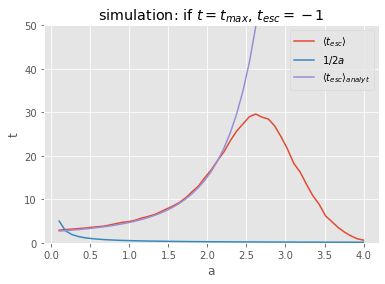

In [249]:
plt.plot(alphas_pos, Tpoints_esc_alphas_mean, label = r'$\langle t_{esc} \rangle$')
plt.plot(alphas_pos, 1/(2*alphas_pos), label = r'$1/2a$')
plt.plot(alphas_pos, T_mean_analyt_exact, label = r'$\langle t_{esc} \rangle_{analyt}$')
plt.xlabel('a')
plt.ylabel('t')
plt.ylim(0, 50)
plt.title(r'simulation: if $t=t_{max}$, $t_{esc}=-1$')
plt.legend()
plt.show()

##### old

In [47]:
X_A = [[] for i in range(n_tra)]
T_esc = [[] for i in range(n_tra)]

In [48]:
for i_tra in range(n_tra): # vectorize it?
    x = x_0
    t = t_0
    while x < x_b:
        uh = np.sqrt(h) * np.random.normal(loc = 0.0, scale = 1.0) #ui, indepednent Gaussian RV
        aux = h * q(x, t, a) + uh * g(x, t, D)
        x = x + 0.5 * (aux + h * q(x + aux, t + h, a) + uh * g(x + aux, t + h, D))
        t = t + h
        if t > t_max:
            print('WARNING. Maximum integration time reached.')
            print('Trajectory, {}, has not crossed the boundary', format(i_tra))
        X_A[i_tra].append(x) 
        T_esc[i_tra].append(t) 
    

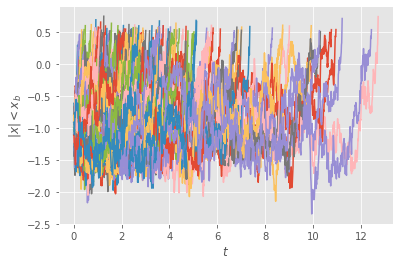

In [49]:
for i in range(100):
    plt.plot(T_esc[i], X_A[i])
plt.xlabel(r'$t$')
plt.ylabel(r'$|x|<x_b$')
# plt.legend()
plt.show()

In [50]:
Tpoints_esc = np.array([sublist[-1] for sublist in T_esc])

In [68]:
xx = np.linspace(0,30,100)
λ = 1/Tpoints_esc.mean()
TT = λ*np.exp(-λ*xx)

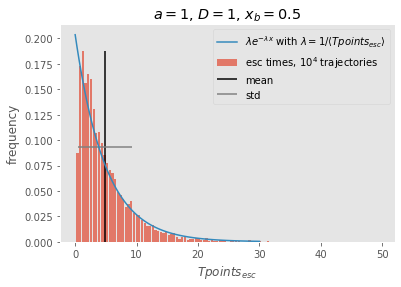

In [69]:
n, bins, patches = plt.hist(x=Tpoints_esc, bins='auto', density = True, # normalized
                            alpha=0.7, rwidth=0.85, label = r'esc times, $10^4$ trajectories')
plt.plot(xx, TT, label = r'$\lambda e^{-\lambda x}$ with $\lambda = 1/\langle Tpoints_{esc} \rangle$')
plt.vlines(Tpoints_esc.mean(), 0, n.max(), color = 'k', label = 'mean')
plt.hlines(n.max()/2, Tpoints_esc.mean() - np.std(Tpoints_esc), Tpoints_esc.mean() + np.std(Tpoints_esc), color = 'gray', label = 'std')
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$Tpoints_{esc}$')
plt.ylabel(r'frequency')
plt.title(r'$a = {}$, $D = {}$, $x_b = {}$'.format(a, D, x_b))
plt.legend()
plt.show()

In [70]:
print(r'the first moment of T, i.e. <T> =',Tpoints_esc.mean())

the first moment of T, i.e. <T> = 4.908654999999957


#### eigenvalues approach under construction...

In [83]:
# Tspace = np.linspace(0, 2.5)
# P_T = 2 / np.pi * np.sin(np.pi * (x_0 + 1)/2) * (np.sin(np.pi * x_b/2) - np.sin(- np.pi * x_b/2)) * np.exp(- np.pi ** 2 * Tspace/4)

In [84]:
# plt.plot(Tspace, P_T);

In [85]:
# n, bins, patches = plt.hist(x=Tpoints_esc, bins='auto', density = True,
#                             alpha=0.7, rwidth=0.85, label = r'esc times, $10^4$ trajectories')
# plt.vlines(Tpoints_esc.mean(), 0, n.max(), color = 'k', label = 'mean')
# plt.hlines(n.max()/2, Tpoints_esc.mean() - np.std(Tpoints_esc), Tpoints_esc.mean() + np.std(Tpoints_esc), color = 'gray', label = 'std')
# plt.plot(Tspace, P_T, label = 'analyt eigenvalues');
# plt.grid(axis='both', alpha=0.75)
# plt.xlabel(r'$Tpoints_{esc}$')
# plt.ylabel(r'frequency')
# plt.legend()
# plt.show()